# Extract C II 6462 line from MUSE cube

In [342]:
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import numpy as np
from numpy.polynomial import Chebyshev as T
from scipy.ndimage import median_filter
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

We have two versions of the cont-subtracted MUSE cubes:
* Rebinned 16x16 cubes are from the Raman project
* Full-resolution cubes are too big for Dropbox, so stored elsewhere

In [2]:
RAW_DATA_PATH = Path.home() / "Dropbox" / "dib-scatter-hii" / "data" / "orion-muse"
RAW_BIG_DATA_PATH = Path.home() / "Work" / "Muse-Hii-Data" / "M42"

## First try with the smaller cube

In [12]:
hdu = fits.open(
    RAW_DATA_PATH / "muse-hr-data-wavsec23-rebin16x16-cont-sub.fits"
)["DATA"]

In [13]:
w = WCS(hdu)
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'AWAV'  
CRVAL : 83.780566  -5.396172  5.7884e-07  
CRPIX : 100.875  45.75  1.0  
CD1_1 CD1_2 CD1_3  : -0.00088888888888888  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000888888888888889  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  8.5e-11  
NAXIS : 110  92  1404

### Find the wavelength pixel that corresponds to the rest wavelength of the C II line

AtLL gives 2 components: 6461.95 and 6462.13, with $g_k A_{ki}$-weighted wavelength of 6462.05:

In [95]:
wav0_6462 = 6462.05 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6462))
k0

792

Take a +/- 50 pixel window around rest wavelength pixel:

In [204]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]

Make an array of wavelengths for the entire cube, and then select the wavs of the window

In [205]:
VOMC = 20.0

In [206]:
nwavs, ny, nx = hdu.data.shape
wavs = w.spectral.array_index_to_world(np.arange(nwavs)).Angstrom
wavs *= (1.0 - VOMC / 3e5)
window_wavs = wavs[window_slice]
window_wavs

array([6418.67206   , 6419.52200333, 6420.37194667, 6421.22189   ,
       6422.07183333, 6422.92177667, 6423.77172   , 6424.62166333,
       6425.47160667, 6426.32155   , 6427.17149333, 6428.02143667,
       6428.87138   , 6429.72132333, 6430.57126667, 6431.42121   ,
       6432.27115333, 6433.12109667, 6433.97104   , 6434.82098333,
       6435.67092667, 6436.52087   , 6437.37081333, 6438.22075667,
       6439.0707    , 6439.92064333, 6440.77058667, 6441.62053   ,
       6442.47047333, 6443.32041667, 6444.17036   , 6445.02030333,
       6445.87024667, 6446.72019   , 6447.57013333, 6448.42007667,
       6449.27002   , 6450.11996333, 6450.96990667, 6451.81985   ,
       6452.66979333, 6453.51973667, 6454.36968   , 6455.21962333,
       6456.06956667, 6456.91951   , 6457.76945333, 6458.61939667,
       6459.46934   , 6460.31928333, 6461.16922667, 6462.01917   ,
       6462.86911333, 6463.71905667, 6464.569     , 6465.41894333,
       6466.26888667, 6467.11883   , 6467.96877333, 6468.81871

Look at the average profile

In [262]:
window_norm = window_cube / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

Also calculate the sky profile, since I am now convinced that most of the other lines are sky.

In [263]:
xskyslice, yskyslice = slice(0, 20), slice(55, 76)
window_sky = np.median(window_norm[:, yskyslice, xskyslice], axis=(1, 2))

Get some potential line IDs from Fang 2011

In [264]:
line_ids = {
    6425.9: "O II",
    6441.295: "[Ni II]",
    6445.81: "Ne II",
#    6451.97: "V II",
    6456.38: "Fe II",
#    6461.95: "C II",
    6462.05: "C II", # mean doublet wavelength
#    6462.13: "C II",
    6466.07: "Fe II",
#    6468.8: "C II",
#    6467.288: "[Ni II]",
#    6469.213: "[Co II]",
    6471.42: "O II",
#    6471.91: "C II",
    6478.72: "N II",
#    6485.2983: "[Fe II]",
#    6483.97: "O II",
#    6485.06: "O II",
#    6491.91: "O II",
    6481.706: " ",
    6482.699: " ",
    6483.753: "N I",
    6484.808: " ",
#    6491.222: "N I",
#    6499.518: " ",
    6501.41: "O II",
#    6506.302: "N I",
#    6507.024: "",
#    6521.110: "N I",
}

In [265]:
def wav2k(wav):
    return w.spectral.world_to_array_index(
         np.asarray(wav) * u.Angstrom
    )

def k2wav(k):
    if len(k):
        return w.spectral.array_index_to_world(
            np.atleast_1d(k)
        ).Angstrom
    else:
        return np.array([])

In [266]:
wav2k(list(line_ids.keys()))

array([750, 768, 773, 786, 793, 797, 804, 812, 816, 817, 818, 819, 839])

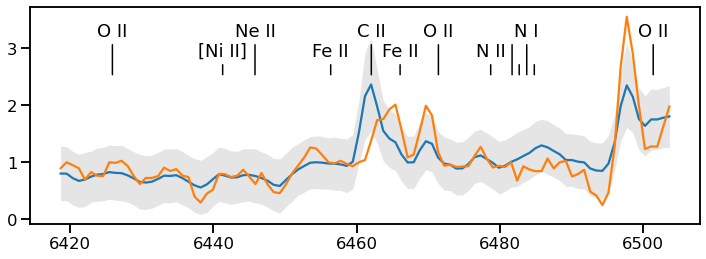

In [267]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_sky)
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 2.5), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1
    

Now try subtracting the average sky spectrum:

In [268]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

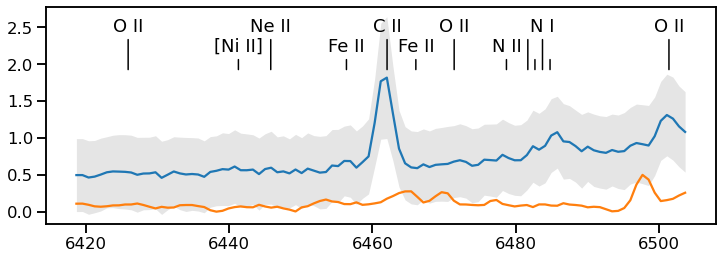

In [269]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, 0.5 * sky[:, 0, 0] / np.max(sky))
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 1.9), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1
    

Yes, that looks a lot better!  So most of the line IDs are not detected at all. It looks very clean around the C II line, with the possible exception of Fe II.  Then, to the red we have a possible detection of the N I multiplet at 6485 and O II at 6502

Now plot against array index 

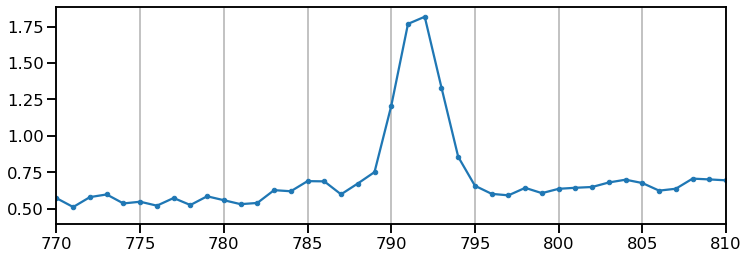

In [270]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.set(
    xlim=[770, 810],
)
ax.grid(axis="x")

770-787 blue continuum. 

796-810 red continuum 

788-795 covers the line

Try it out:

In [279]:
myav = np.mean
fullsky = myav(
    hdu.data[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
fullcube_nosky = hdu.data - fullsky
cont_map_blue = myav(fullcube_nosky[770:788, ...], axis=0)
cont_map_red = myav(fullcube_nosky[796:810, ...], axis=0)
cont_map = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
cii_map = (fullcube_nosky[788:796, ...] - cont_map).sum(axis=0)

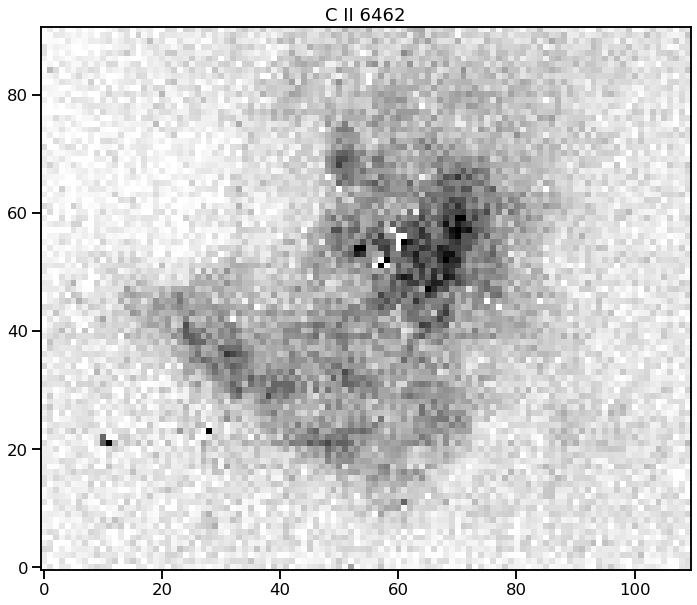

In [288]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii_map, vmin=-3e4, vmax=6e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

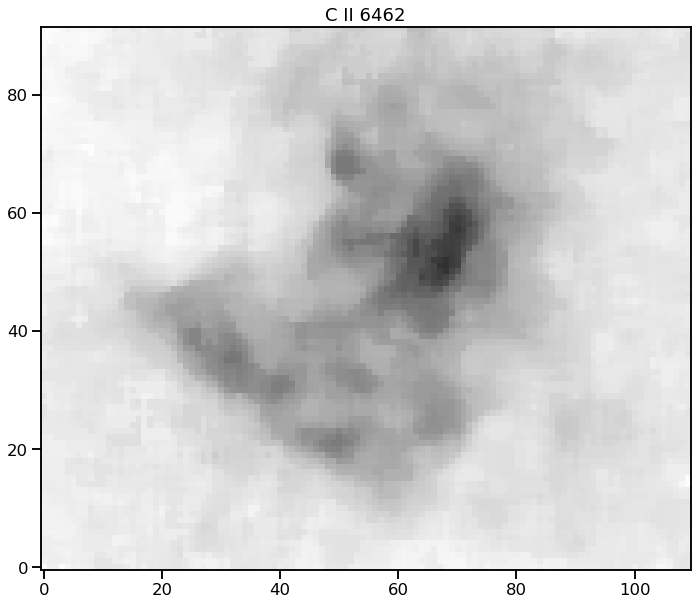

In [355]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 5
ax.imshow(
    median_filter(cii_map, size=smooth), 
    vmin=-3e4, vmax=6e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

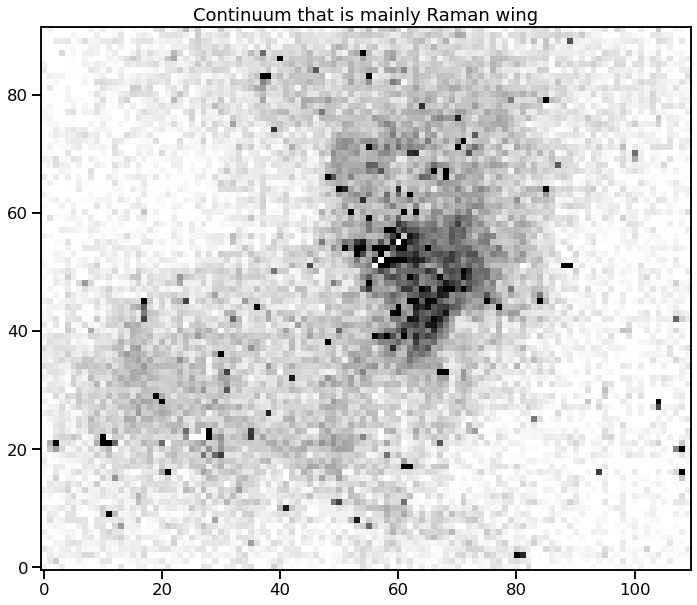

In [286]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map, vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

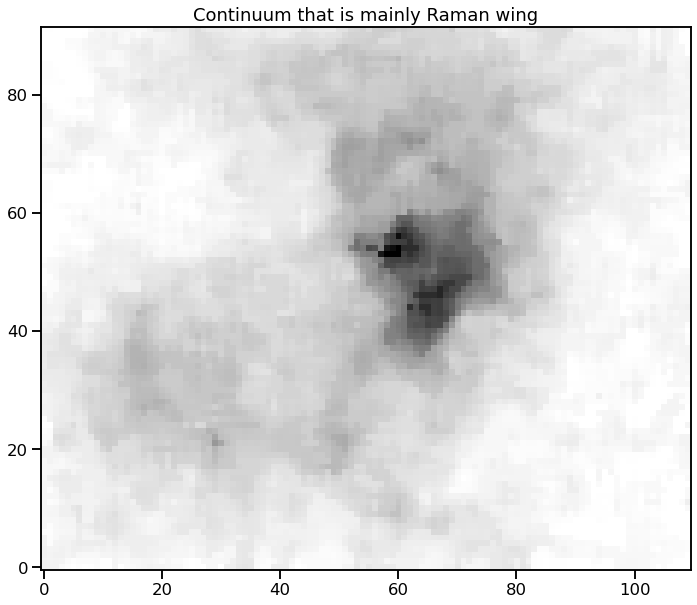

In [365]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 4
ax.imshow(
    median_filter(cont_map, size=smooth), 
    vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

## Compare with H alpha

In [289]:
wav0_6563 = 6562.79 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6563))
k0

911

In [290]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]
window_wavs = wavs[window_slice]
window_wavs

array([6519.81531667, 6520.66526   , 6521.51520333, 6522.36514667,
       6523.21509   , 6524.06503333, 6524.91497667, 6525.76492   ,
       6526.61486333, 6527.46480667, 6528.31475   , 6529.16469333,
       6530.01463667, 6530.86458   , 6531.71452333, 6532.56446667,
       6533.41441   , 6534.26435333, 6535.11429667, 6535.96424   ,
       6536.81418333, 6537.66412667, 6538.51407   , 6539.36401333,
       6540.21395667, 6541.0639    , 6541.91384333, 6542.76378667,
       6543.61373   , 6544.46367333, 6545.31361667, 6546.16356   ,
       6547.01350333, 6547.86344667, 6548.71339   , 6549.56333333,
       6550.41327667, 6551.26322   , 6552.11316333, 6552.96310667,
       6553.81305   , 6554.66299333, 6555.51293667, 6556.36288   ,
       6557.21282333, 6558.06276667, 6558.91271   , 6559.76265333,
       6560.61259667, 6561.46254   , 6562.31248333, 6563.16242667,
       6564.01237   , 6564.86231333, 6565.71225667, 6566.5622    ,
       6567.41214333, 6568.26208667, 6569.11203   , 6569.96197

In [291]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

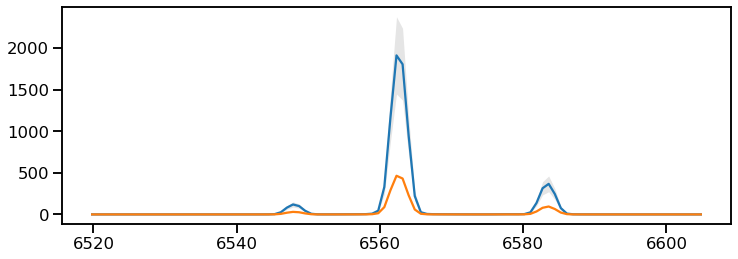

In [294]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_mad)

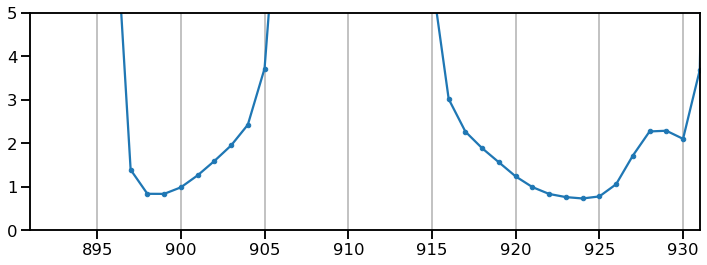

In [300]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.set(
    xlim=[k0 - 20, k0 + 20],
    ylim=[0, 5],
)
ax.grid(axis="x")

In [307]:
cont_map_blue = myav(fullcube_nosky[898:901, ...], axis=0)
cont_map_red = myav(fullcube_nosky[922:925, ...], axis=0)
cont_map_ha = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
ha_map = (fullcube_nosky[906:916, ...] - cont_map_ha).sum(axis=0)

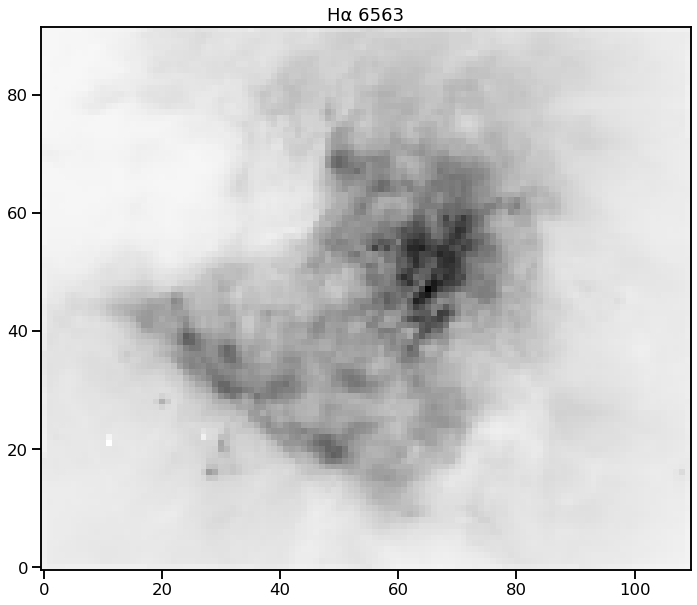

In [308]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(ha_map, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563");

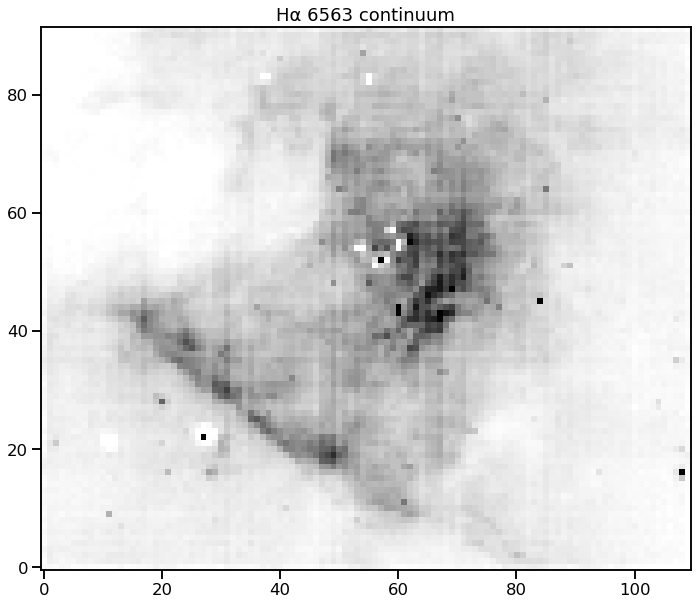

In [310]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map_ha, vmin=0, vmax=1e6, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563 continuum");

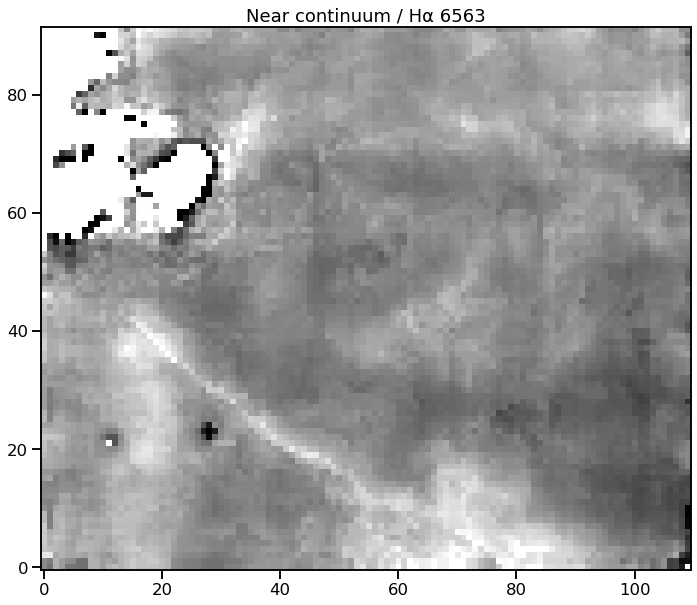

In [388]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.01 * np.median(ha_map)
smooth = 4
ratio = (
    median_filter(cont_map_ha, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=0, 
    vmax=2.5e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("Near continuum / Hα 6563");

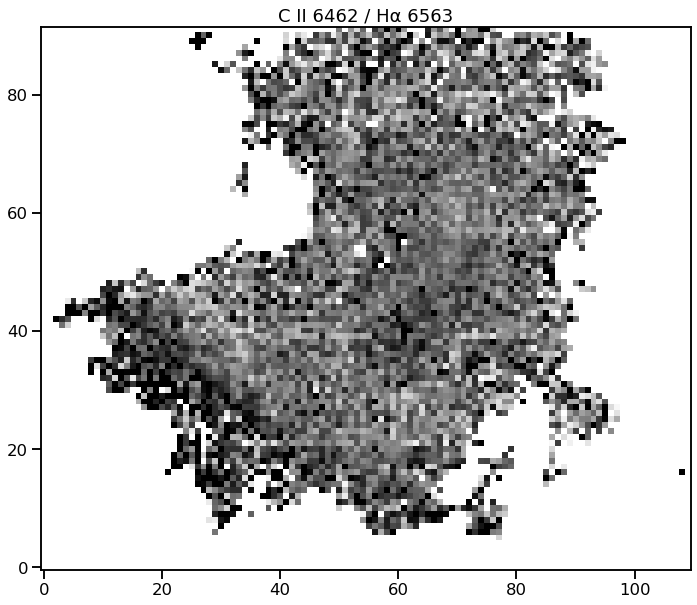

In [341]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 1 * np.median(ha_map)
ratio = cii_map / ha_map
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("C II 6462 / Hα 6563");

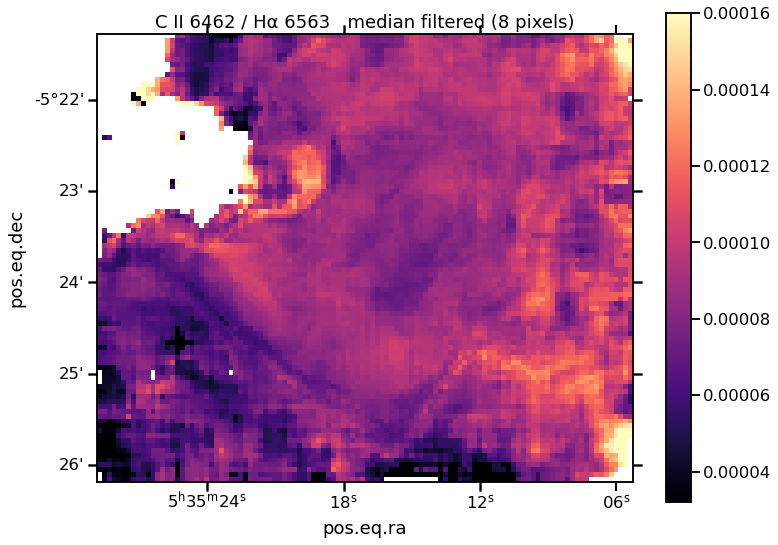

In [372]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=w.celestial),
)
mask = ha_map < 0.2 * np.median(ha_map)
smooth = 8
ratio = (
    median_filter(cii_map, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="magma",
)
fig.colorbar(im, ax=ax)
ax.set_title(f"C II 6462 / Hα 6563   median filtered ({smooth} pixels)");

So the typical value is 1e-4.  We can estimate the C++/H+ abundance by looking at the effective recombination rates.

## Now try and extract 6578

Find the shift in wav pixels between the two [N II] lines.

In [400]:
NWIN = 160
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]
window_wavs = wavs[window_slice]
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))

In [401]:
wav0_6548 = 6548.05 * u.Angstrom
wav0_6583 = 6583.45 * u.Angstrom
k0_6548 = w.spectral.world_to_pixel(wav0_6548)
k0_6583 = w.spectral.world_to_pixel(wav0_6583)
k0_6548, k0_6583

(array(893.70588235), array(935.35294118))

In [402]:
kshift = k0_6583 - k0_6548
kshift

41.64705882352928

In [407]:
kwindow = wav2k(window_wavs)
kfull = np.arange(nwavs)

In [421]:
p = T.fit(kwindow[:40], window_median[:40], deg=2)
p2 = T.fit(kwindow[-40:], window_median[-40:], deg=2)

In [459]:
window_shift = np.interp(
    kwindow, 
    kwindow + kshift,
    3 * (window_median - 0.85 * p(kwindow)),
)

In [475]:
from scipy.ndimage import convolve
delta = 0.105
kernel = np.array([delta, 1.0 - 2 * delta, delta])
window_median_smooth = convolve(window_median, kernel)

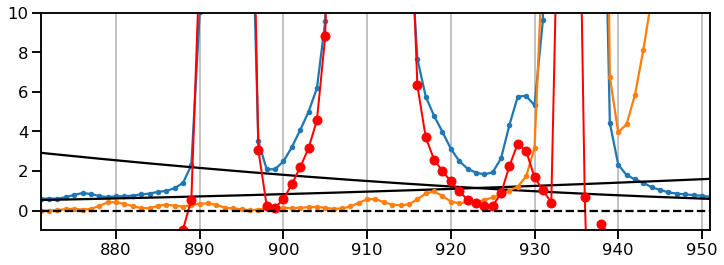

In [477]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwindow, window_median, marker=".")
ax.plot(kwindow, 0.9 * p(kwindow), color="k")
ax.plot(kwindow, 0.9 * p2(kwindow), color="k")
ax.plot(kwindow, window_shift, marker=".")
ax.plot(
    kwindow, 
    window_median_smooth - window_shift - 0.9 * p2(kwindow), 
    marker="o", color="r", lw=2)

ax.axhline(0.0, color="k", linestyle="dashed")
ax.set(
    xlim=[k0 - 40, k0 + 40],
    ylim=[-1, 10],
)
ax.grid(axis="x")

In [478]:
wav0_6578 = 6578.05 * u.Angstrom
k0_6578 = w.spectral.world_to_pixel(wav0_6578)
k0_6578

array(929.)